# World Happiness Classification

## 0. Importing data and setting up X_train, X_test, y_train objects

In [3]:
from zipfile import ZipFile

with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
    zObject.extractall()

In [4]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

In [5]:
countrydata=pd.read_csv("newcountryvars.csv")
countrydata.rename({'country_name':'Country or region'},axis=1,inplace=1)
X_train=X_train.merge(countrydata,on='Country or region',how='left')
X_test=X_test.merge(countrydata,on='Country or region',how='left')

## 1. Exploratory Data Analysis

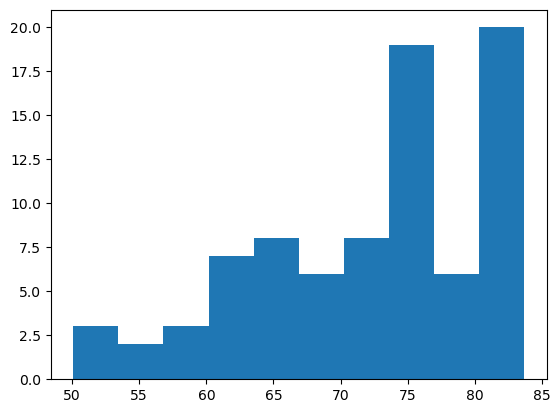

In [6]:
from matplotlib import pyplot as plt

plt.hist(X_train['life_expectancy'])
plt.show()

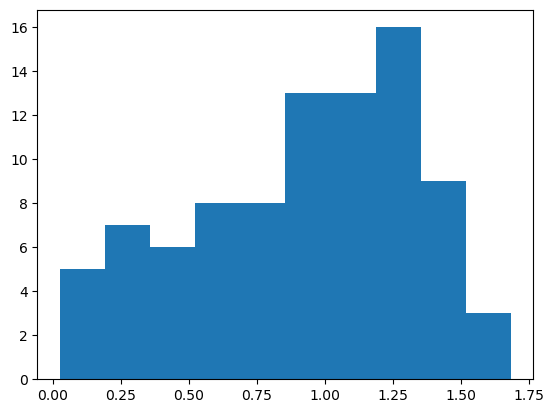

In [7]:
plt.hist(X_train['GDP per capita'])
plt.show()

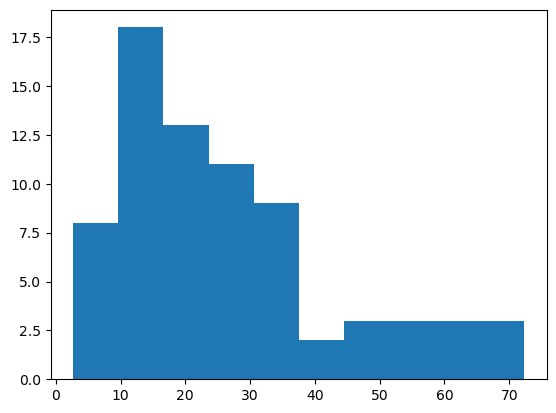

In [8]:
plt.hist(X_train['population_below_poverty_line'])
plt.show()

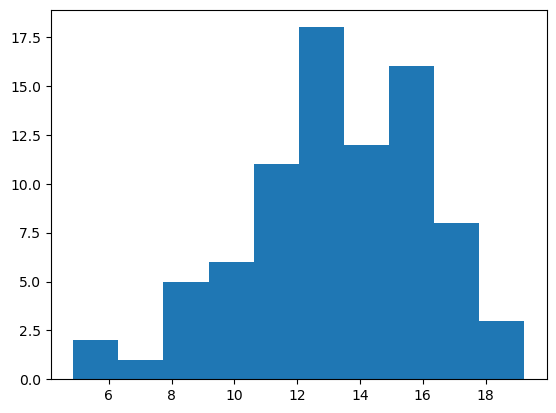

In [9]:
plt.hist(X_train['expected_years_of_schooling'])
plt.show()

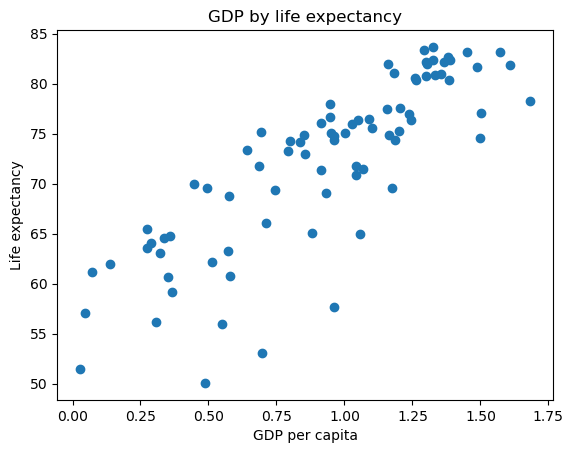

In [10]:
plt.scatter(X_train['GDP per capita'], X_train['life_expectancy'])
plt.title("GDP by life expectancy")
plt.xlabel("GDP per capita")
plt.ylabel("Life expectancy")
plt.show()

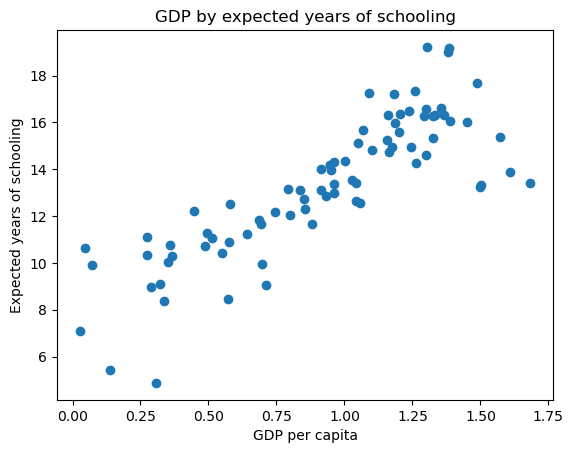

In [11]:
plt.scatter(X_train['GDP per capita'], X_train['expected_years_of_schooling'])
plt.title("GDP by expected years of schooling")
plt.xlabel("GDP per capita")
plt.ylabel("Expected years of schooling")
plt.show()

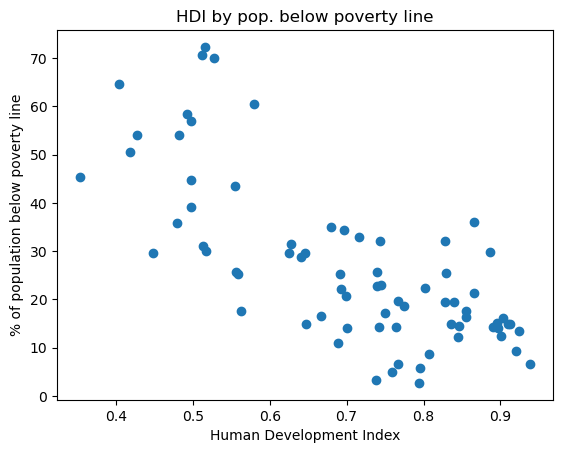

In [12]:
plt.scatter(X_train['hdi'], X_train['population_below_poverty_line'])
plt.title("HDI by pop. below poverty line")
plt.xlabel("Human Development Index")
plt.ylabel("% of population below poverty line")
plt.show()

<Axes: ylabel='GDP per capita'>

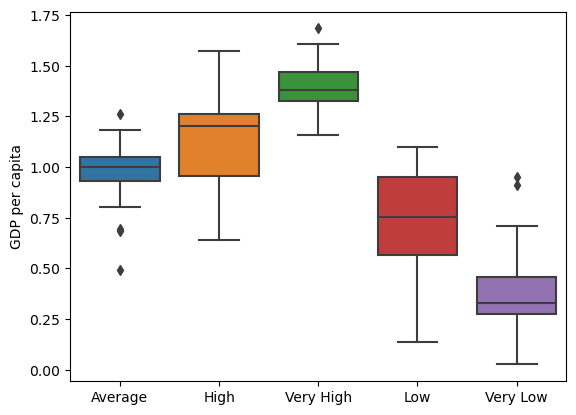

In [13]:
import seaborn as sns

sns.boxplot(x = y_train_labels,
            y = X_train['GDP per capita'])

<Axes: ylabel='life_expectancy'>

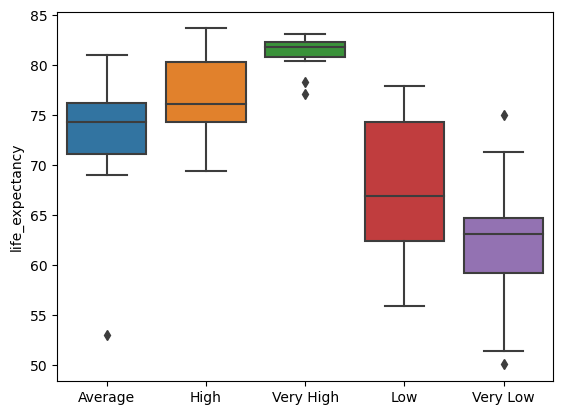

In [14]:
sns.boxplot(x = y_train_labels,
            y = X_train['life_expectancy'])

<Axes: ylabel='population_below_poverty_line'>

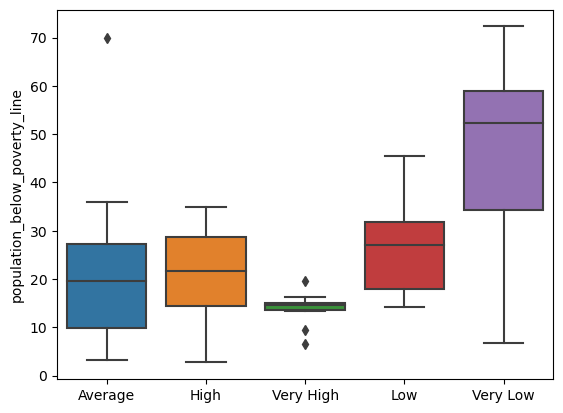

In [15]:
sns.boxplot(x = y_train_labels,
            y = X_train['population_below_poverty_line'])

Looking at scatter plots between various numerical variables, we see that GDP and life expectancy tend to move up together or countries with higher GDP per capita also tend to have higher life expectancy. Similarly, countries with higher GDP per capita have higher expected years of schooling. We also see that a higher human development index corresponds to a lower proportion of population below the poverty line.

We use boxplots to look at how various levels of happiness levels are associated with the numerical features. First, we see that higher levels of happiness correspond to higher GDP per capita on average, by the mean of the boxplot as well as its overall range. We see a similar trend with life expectancy. With population below the poverty line, thet trend is not as clear but generally we see that lower levels of happiness correspond to higher proportions below the poverty line and vice versa.

## 2. Preprocessing data


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X_train.select_dtypes(exclude=['object'])
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocess=preprocessor.fit(X_train)

In [17]:
def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

## 3. Fitting models

### Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'max_depth': np.arange(1,11,2)}

gridmodel = GridSearchCV(RandomForestClassifier(n_estimators=100,random_state=51), param_grid=param_grid, cv=skfold)

gridmodel.fit(preprocessor(X_train), y_train_labels)

print("Best parameters: {}".format(gridmodel.best_params_))
print("Best mean cross-validation score: {:.4f}".format(gridmodel.best_score_))

print("Training set score: {:.4f}".format(gridmodel.score(preprocessor(X_train), y_train_labels)))

Best parameters: {'max_depth': 7}
Best mean cross-validation score: 0.6591
Training set score: 1.0000


### KNN Classifier

In [19]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1,15,2)}

gridmodel_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=skfold)
gridmodel_knn.fit(preprocessor(X_train), y_train_labels)

print("Best parameters: {}".format(gridmodel_knn.best_params_))
print("Best mean cross-validation score: {:.4f}".format(gridmodel_knn.best_score_))

print("Training set score: {:.4f}".format(gridmodel_knn.score(preprocessor(X_train), y_train_labels)))

Best parameters: {'n_neighbors': 9}
Best mean cross-validation score: 0.6364
Training set score: 0.7159


### KVM

In [20]:
from sklearn.svm import SVC

param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

gridmodel_svc = GridSearchCV(SVC(), param_grid=param_grid, cv=skfold)
gridmodel_svc.fit(preprocessor(X_train), y_train_labels)

print("Best parameters: {}".format(gridmodel_svc.best_params_))
print("Best mean cross-validation score: {:.4f}".format(gridmodel_svc.best_score_))

print("Training set score: {:.4f}".format(gridmodel_svc.score(preprocessor(X_train), y_train_labels)))

Best parameters: {'C': 10, 'gamma': 0.005}
Best mean cross-validation score: 0.7045
Training set score: 0.8068


With random forest models, there are a few parameters that we can adjust- n_estimators, max_depth, and max_features. I simply set n_estimators at 100 for code running efficiency. For max_depth, GridSearchCV found the most optimal value to be 7, i.e. it stopped the tree building process early to avoid overfititng. max_features also helps mitigate overfitting, but tends to perform better with the default settings (square root of number of features) so I did not tune this parameter.

The only parameter we needed to set for the KNN model was the number of neighbors, k, which controls the number of closest training data points we utilize to make the prediction for our new point. To find the optimal k, we did hyperparameter tuning using GridSearchCV to search through all the odd numbers between 1 and 15 (to avoid ties). To evaluate which parameter generalized the best, we selected the parameter value that resulted in the best mean cross-validation score using cross-validation.

Based on GridSearchCV, we found that the optimal number of neighbors is 9. Higher number of neighbors corresponds to lower model complexity, which in turn produces models that generalize better and avoid overfitting to the training data.

The other model we attempted was Kernelized Support Vector Machine, or simply KVM, using the radial basis function kernel (RBF). Its parameters are C and gamma. C is the regularization parameter which constrains the magnitude of coefficients to reduce overfitting, while gamma controls the width of the kernels (determining scale of closeness).

From GridSearchCV, we found that the optimal gamma was 0.005, while C was 10. A small gamma means a large radius for the kernel, or that many points are considered to be close together. C being 10 indicates a relatively more restricted model. C and gamma move together, so with both values on the lower end, we have a low complexity model.

### Basic Deep Learning

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

feature_count = len(preprocessor(X_train)[1])

keras_model= Sequential([
    Dense(128, input_dim=feature_count, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')])

keras_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

keras_model.fit(preprocessor(X_train), y_train,
               batch_size = 20,
               epochs = 300, validation_split=0.25,
               verbose=0)

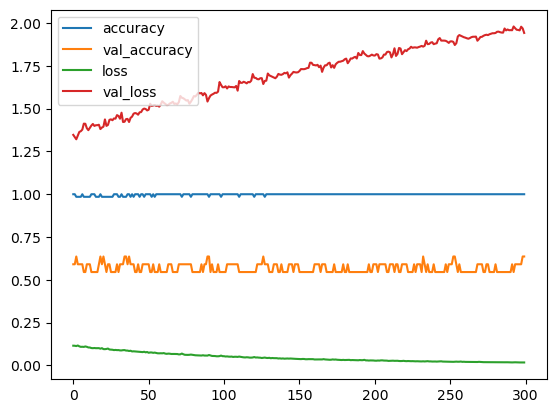

In [22]:
model_hist = keras_model.fit(preprocessor(X_train), y_train,
                          batch_size = 20, epochs = 300, validation_split=0.25, verbose=0)
acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']
plt.plot(acc)
plt.plot(val_acc)
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['accuracy', 'val_accuracy','loss', 'val_loss'])
plt.show()